<a href="https://colab.research.google.com/github/Papagoat/sentiment-analysis-shopee-layoffs-reddit/blob/main/Shopee_Layoff_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install asyncpraw

In [2]:
import asyncpraw
import json
import matplotlib.pyplot as plt
import numpy
import pandas as pd
from pandas import json_normalize

## Extract Comments using PRAW

In [3]:
reddit = asyncpraw.Reddit(
 client_id='<Your-Client-ID>',
 client_secret='<Your-Client-Secret>',
 user_agent=f'<Your-User_Agent>'
)

In [4]:
submission_list = ["x1hltt", "x2uw99", "x959w2", "vbsv76", "vd9xtw", "tq5on7", "x1hhq8"]
comment_list = []
for list in submission_list:
  submission = await reddit.submission(id=list)
  comments = await submission.comments()
  await comments.replace_more(limit=None)
  comment_queue = comments[:]  # Seed with top-level
  while comment_queue:
      comment = comment_queue.pop(0)
      comment_list.append(comment.body)
      comment_queue.extend(comment.replies)

In [5]:
reddit_comments = [comments for comments in comment_list]
df = pd.DataFrame(reddit_comments)
df = df.rename({0: 'comments'}, axis=1)
df['id'] = df.index
df.head()

,comments,id
0,Apparently there was this guy from China who f...,0
1,"Incorporated in Singapore, headquartered in Si...",1
2,Shopee Group of companies is an employer to be...,2
3,Is shopee Chinese dominated? How come they can...,3
4,"I work in FAANG, everyone in the software indu...",4


# Data cleanup

In [6]:
df['comments'] = df['comments'].map(
    lambda x: x
    # .replace('\n', '')
    # .replace('&amp;', '')
    # .replace('#x200B;', '')
    # .replace('&gt;', '')
    .replace('#', '')
    .replace('**', '')
    # .replace('?', '')
    .replace('\\', '')
    # .replace('"', '')
    .replace(">", '')
    .replace("...", '')
    .replace("\n", ' ')
    .replace("[deleted]", '')
    )
df.head()

,comments,id
0,Apparently there was this guy from China who f...,0
1,"Incorporated in Singapore, headquartered in Si...",1
2,Shopee Group of companies is an employer to be...,2
3,Is shopee Chinese dominated? How come they can...,3
4,"I work in FAANG, everyone in the software indu...",4


# Sentiment Analysis using Vader Sentiment Scoring

In [ ]:
import nltk 
nltk.download('punkt')
nltk.download('vader_lexicon')

from nltk.sentiment import SentimentIntensityAnalyzer
sentiment_analyzer = SentimentIntensityAnalyzer()

In [8]:
res = {}
for i, row in df.iterrows():
  comments = row['comments']
  id = row['id']
  res[id] = sentiment_analyzer.polarity_scores(comments)

In [9]:
vader_df = pd.DataFrame(res).T
vader_df = vader_df.reset_index().rename(columns={'index': 'id'})
vader_df = vader_df.merge(df, how='left')
vader_df.head()

,id,neg,neu,pos,compound,comments
0,0,0.030,0.893,0.077,0.5423,Apparently there was this guy from China who f...
1,1,0.000,0.852,0.148,0.4497,"Incorporated in Singapore, headquartered in Si..."
2,2,0.074,0.890,0.036,-0.5484,Shopee Group of companies is an employer to be...
3,3,0.000,0.914,0.086,0.3527,Is shopee Chinese dominated? How come they can...
4,4,0.109,0.891,0.000,-0.2960,"I work in FAANG, everyone in the software indu..."


In [10]:
total_neg = vader_df['neg'].sum()
total_neu = vader_df['neu'].sum()
total_pos = vader_df['pos'].sum()
total_compound = vader_df['compound'].sum()
total_sum = total_neg + total_neu + total_pos

In [11]:
print(f'Total sum of negative sentiments: {total_neg}')
print(f'Total sum of neutral sentiments: {total_neu}')
print(f'Total sum of positive sentiments: {total_pos}')
print(f'Total compound sum: {total_compound}')
print(f'Total sum: {total_sum}')

Total sum of negative sentiments: 40.985
Total sum of neutral sentiments: 386.392
Total sum of positive sentiments: 54.629
Total compound sum: 39.1734
Total sum: 482.00600000000003


In [12]:
total_neg_perc = (total_neg/total_sum) * 100
total_neu_perc = (total_neu/total_sum) * 100
total_pos_perc = (total_pos/total_sum) * 100

In [13]:
print(f'Total percentage of negative sentiments: {round(total_neg_perc, 2)}')
print(f'Total percentage of neutral sentiments: {round(total_neu_perc, 2)}')
print(f'Total percentage of positive sentiments: {round(total_pos_perc, 2)}')

Total percentage of negative sentiments: 8.5
Total percentage of neutral sentiments: 80.16
Total percentage of positive sentiments: 11.33


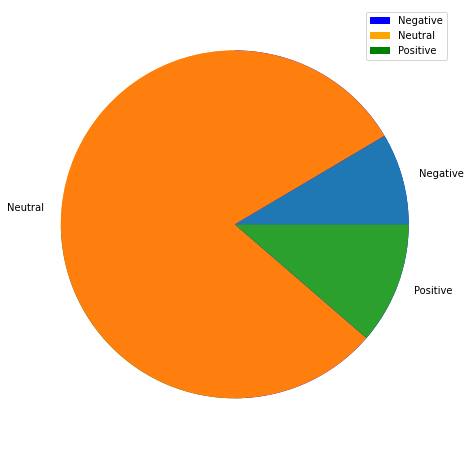

In [14]:
y = numpy.array([total_neg_perc, total_neu_perc, total_pos_perc])
mylabels = ["Negative", "Neutral", "Positive"]
plt.figure(figsize=(8,8))

sizes = [10, 10, 10, 10]
colors = ['blue', 'orange', 'green']
patches, texts = plt.pie(sizes, colors=colors)
plt.legend(patches, mylabels, loc="best")

plt.axis('off')

plt.pie(y, labels=mylabels)
plt.show() 

# Sentiment Analysis using Roberta Pretrained Model

In [ ]:
!pip install transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

In [ ]:
MODEL = "j-hartmann/emotion-english-distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# Function to compute polarity scores

In [17]:
def return_polarity_scores(df):
  encoded_text = tokenizer(df, return_tensors='pt')
  output = model(**encoded_text)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)
  scores_dict = {
      'anger': scores[0],
      'disgust': scores[1],
      'fear': scores[2],
      'joy': scores[3],
      'neutral': scores[4],
      'sadness': scores[5],
      'surprise': scores[6],
  }
  return scores_dict

In [18]:
res = {}
for i, row in df.iterrows():
  try:
    comments = row['comments']
    id = row['id']
    res[id] = return_polarity_scores(comments)
  except RuntimeError:
    print(f'Error on row {i}')

Token indices sequence length is longer than the specified maximum sequence length for this model (756 > 512). Running this sequence through the model will result in indexing errors


Error on row 120
Error on row 286


In [19]:
roberta_df = pd.DataFrame(res).T
roberta_df = roberta_df.reset_index().rename(columns={'index': 'id'})
roberta_df = roberta_df.merge(df, how='left')
roberta_df.head()

,id,anger,disgust,fear,joy,neutral,sadness,surprise,comments
0,0,0.813459,0.027911,0.007090,0.003568,0.081237,0.045780,0.020956,Apparently there was this guy from China who f...
1,1,0.046959,0.465010,0.014762,0.041402,0.314252,0.098423,0.019192,"Incorporated in Singapore, headquartered in Si..."
2,2,0.012008,0.912001,0.019919,0.001120,0.019736,0.025168,0.010048,Shopee Group of companies is an employer to be...
3,3,0.035159,0.011472,0.006887,0.002311,0.404050,0.013801,0.526320,Is shopee Chinese dominated? How come they can...
4,4,0.007821,0.008161,0.016217,0.003423,0.889725,0.006688,0.067966,"I work in FAANG, everyone in the software indu..."


In [20]:
total_anger = roberta_df['anger'].sum()
total_disgust = roberta_df['disgust'].sum()
total_fear = roberta_df['fear'].sum()
total_joy = roberta_df['joy'].sum()
total_neutral = roberta_df['neutral'].sum()
total_sadness = roberta_df['sadness'].sum()
total_surprise = roberta_df['surprise'].sum()

total_sum = (total_anger + 
             total_disgust + 
             total_fear + 
             total_joy + 
             total_neutral + 
             total_sadness + 
             total_surprise)

In [21]:
print(f'Total sum of anger sentiments: {total_anger}')
print(f'Total sum of disgust sentiments: {total_disgust}')
print(f'Total sum of fear sentiments: {total_fear}')
print(f'Total sum of joy sentiments: {total_joy}')
print(f'Total sum of neutral sentiments: {total_neutral}')
print(f'Total sum of sadness sentiments: {total_sadness}')
print(f'Total sum of surprise sentiments: {total_surprise}')
print(f'Total sum: {total_sum}')

Total sum of anger sentiments: 40.733245849609375
Total sum of disgust sentiments: 50.129093170166016
Total sum of fear sentiments: 17.652873992919922
Total sum of joy sentiments: 25.955018997192383
Total sum of neutral sentiments: 222.17550659179688
Total sum of sadness sentiments: 44.695899963378906
Total sum of surprise sentiments: 89.65837097167969
Total sum: 491.0


In [22]:
total_anger_perc = (total_anger/total_sum) * 100
total_disgust_perc = (total_disgust/total_sum) * 100
total_fear_perc = (total_fear/total_sum) * 100
total_joy_perc = (total_joy/total_sum) * 100
total_neutral_perc = (total_neutral/total_sum) * 100
total_sadness_perc = (total_sadness/total_sum) * 100
total_surprise_perc = (total_surprise/total_sum) * 100

In [23]:
print(f'Percentage of anger sentiments: {round(total_anger_perc, 2)}')
print(f'Percentage of disgust sentiments: {round(total_disgust_perc, 2)}')
print(f'Percentage of fear sentiments: {round(total_fear_perc, 2)}')
print(f'Percentage of joy sentiments: {round(total_joy_perc, 2)}')
print(f'Percentage of neutral sentiments: {round(total_neutral_perc, 2)}')
print(f'Percentage of sadness sentiments: {round(total_sadness_perc, 2)}')
print(f'Percentage of surprise sentiments: {round(total_surprise_perc, 2)}')

Percentage of anger sentiments: 8.3
Percentage of disgust sentiments: 10.21
Percentage of fear sentiments: 3.6
Percentage of joy sentiments: 5.29
Percentage of neutral sentiments: 45.25
Percentage of sadness sentiments: 9.1
Percentage of surprise sentiments: 18.26


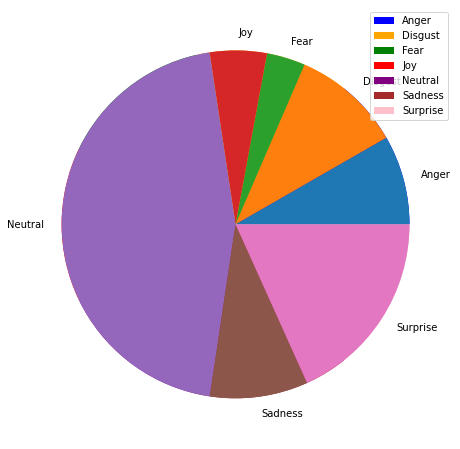

In [24]:
y = numpy.array([
    total_anger_perc,
    total_disgust_perc,
    total_fear_perc,
    total_joy_perc,
    total_neutral_perc,
    total_sadness_perc,
    total_surprise_perc
  ])
mylabels = ["Anger", "Disgust", "Fear", "Joy", "Neutral", "Sadness", "Surprise"]
plt.figure(figsize=(8,8))
# plt.clf()

sizes = [10, 10, 10, 10, 10, 10, 10]
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink']
patches, texts = plt.pie(sizes, colors=colors)
plt.legend(patches, mylabels, loc="best")

plt.axis('off')

plt.pie(y, labels=mylabels)
plt.show() 

# Sentiment Analysis Using Transformers

In [ ]:
from transformers import pipeline
model_path = "cardiffnlp/twitter-roberta-base-sentiment-latest"
sent_pipeline = pipeline("sentiment-analysis", model=model_path, tokenizer=model_path)

In [26]:
res = {}
for i, row in df.iterrows():
  try:
    comments = row['comments']
    id = row['id']
    res[id] = sent_pipeline(comments)
  except RuntimeError:
    print(f'Error on row {i}')

Error on row 120
Error on row 286


In [27]:
pipeline_df = pd.DataFrame(res).T
pipeline_df = pd.json_normalize(pipeline_df[pipeline_df.columns[0]])
pipeline_df = pipeline_df.reset_index().rename(columns={'index': 'id'})
pipeline_df = pipeline_df.merge(df, how='left')
pipeline_df.head()

,id,label,score,comments
0,0,Negative,0.635562,Apparently there was this guy from China who f...
1,1,Neutral,0.849891,"Incorporated in Singapore, headquartered in Si..."
2,2,Negative,0.795792,Shopee Group of companies is an employer to be...
3,3,Negative,0.496090,Is shopee Chinese dominated? How come they can...
4,4,Neutral,0.493178,"I work in FAANG, everyone in the software indu..."


In [28]:
total_neg = len(pipeline_df.loc[pipeline_df['label'] == 'Negative'])
total_neu = len(pipeline_df.loc[pipeline_df['label'] == 'Neutral'])
total_pos = len(pipeline_df.loc[pipeline_df['label'] == 'Positive'])

In [29]:
print(f'Total sum of negative sentiments: {total_neg}')
print(f'Total sum of neutral sentiments: {total_neu}')
print(f'Total sum of positive sentiments: {total_pos}')

Total sum of negative sentiments: 220
Total sum of neutral sentiments: 211
Total sum of positive sentiments: 60


In [30]:
total_pipeline_neg_sum = pipeline_df.loc[pipeline_df['label'] == 'Negative'].score.sum()
total_pipeline_neu_sum = pipeline_df.loc[pipeline_df['label'] == 'Neutral'].score.sum()
total_pipeline_pos_sum = pipeline_df.loc[pipeline_df['label'] == 'Positive'].score.sum()
total_pipeline_sum = total_pipeline_neg_sum + total_pipeline_neu_sum + total_pipeline_pos_sum

In [31]:
print(f'Total score of negative sentiments: {total_pipeline_neg_sum}')
print(f'Total score of neutral sentiments: {total_pipeline_neu_sum}')
print(f'Total score of positive sentiments: {total_pipeline_pos_sum}')

Total score of negative sentiments: 167.4061914384365
Total score of neutral sentiments: 147.81790852546692
Total score of positive sentiments: 40.31434741616249


In [32]:
total_pipeline_neg_perc = (total_pipeline_neg_sum/total_pipeline_sum) * 100
total_pipeline_neu_perc = (total_pipeline_neu_sum/total_pipeline_sum) * 100
total_pipeline_pos_perc = (total_pipeline_pos_sum/total_pipeline_sum) * 100

In [33]:
print(f'Percentage of negative sentiments: {round(total_pipeline_neg_perc, 2)}')
print(f'Percentage of neutral sentiments: {round(total_pipeline_neu_perc, 2)}')
print(f'Percentage of positive sentiments: {round(total_pipeline_pos_perc, 2)}')

Percentage of negative sentiments: 47.09
Percentage of neutral sentiments: 41.58
Percentage of positive sentiments: 11.34


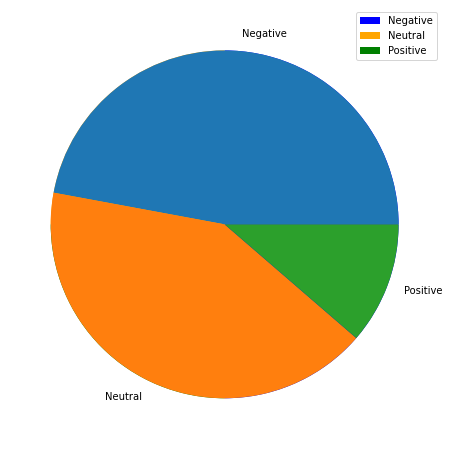

In [34]:
y = numpy.array([total_pipeline_neg_perc, total_pipeline_neu_perc, total_pipeline_pos_perc])
mylabels = ["Negative", "Neutral", "Positive"]


plt.figure(figsize=(8,8))
# plt.clf()

sizes = [10, 10, 10, 10]
colors = ['blue', 'orange', 'green']
patches, texts = plt.pie(sizes, colors=colors)
plt.legend(patches, mylabels, loc="best")

plt.axis('off')

plt.pie(y, labels=mylabels)
plt.show() 

In [35]:
pipeline_df_loc_all_tokenized = [",".join([str(item.lower()) for item in pipeline_df['comments']])]

pipeline_df_loc_neg = pipeline_df.loc[pipeline_df['label'] == 'Negative']
pipeline_df_loc_neg_tokenized = [",".join([str(item.lower()) for item in pipeline_df_loc_neg['comments']])]

pipeline_df_loc_neu = pipeline_df.loc[pipeline_df['label'] == 'Neutral']
pipeline_df_loc_neu_tokenized = [",".join([str(item.lower()) for item in pipeline_df_loc_neu['comments']])]

pipeline_df_loc_pos = pipeline_df.loc[pipeline_df['label'] == 'Positive']
pipeline_df_loc_pos_tokenized = [",".join([str(item.lower()) for item in pipeline_df_loc_pos['comments']])]

# Tokenise each word in the comments

In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords
en_stops = stopwords.words('english')

In [37]:
from wordcloud import WordCloud
wordcloud_all = WordCloud(stopwords=en_stops, background_color='black', max_words=200).generate(pipeline_df_loc_all_tokenized[0])
wordcloud_neg = WordCloud(stopwords=en_stops, background_color='black', max_words=200).generate(pipeline_df_loc_neg_tokenized[0])
wordcloud_neu = WordCloud(stopwords=en_stops, background_color='black', max_words=200).generate(pipeline_df_loc_neu_tokenized[0])
wordcloud_pos = WordCloud(stopwords=en_stops, background_color='black', max_words=200).generate(pipeline_df_loc_pos_tokenized[0])

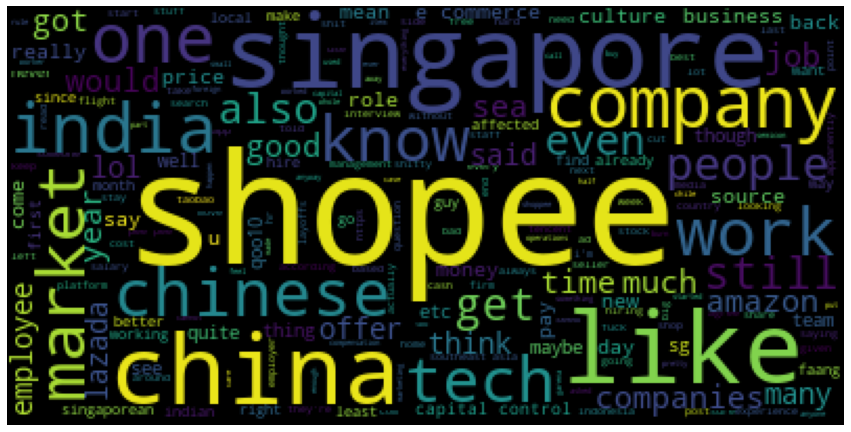

In [38]:
plt.figure(figsize=(15,10))
plt.clf()
plt.imshow(wordcloud_all)
plt.axis('off')
plt.show()

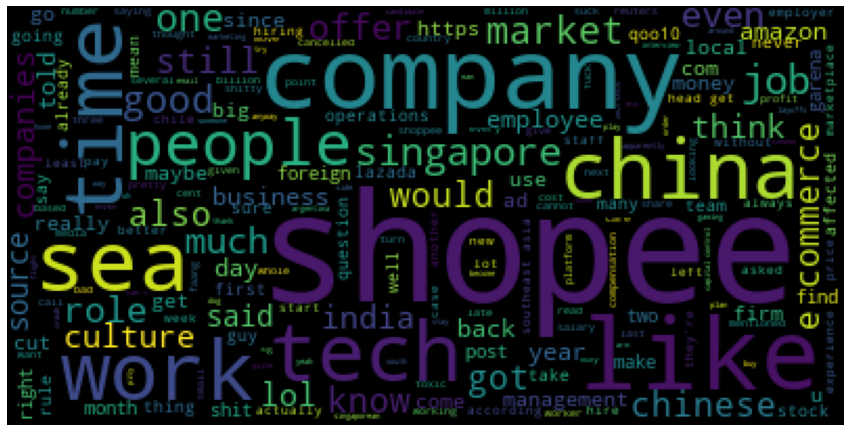

In [39]:
plt.figure(figsize=(15,10))
plt.clf()
plt.imshow(wordcloud_neg)
plt.axis('off')
plt.show()

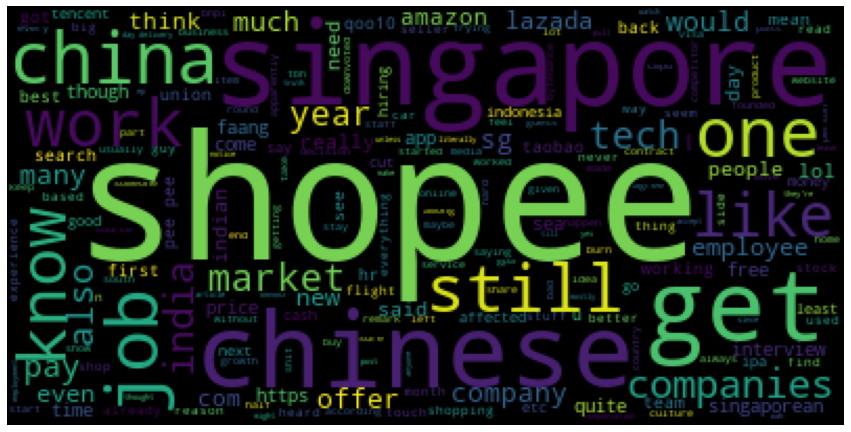

In [40]:
plt.figure(figsize=(15,10))
plt.clf()
plt.imshow(wordcloud_neu)
plt.axis('off')
plt.show()

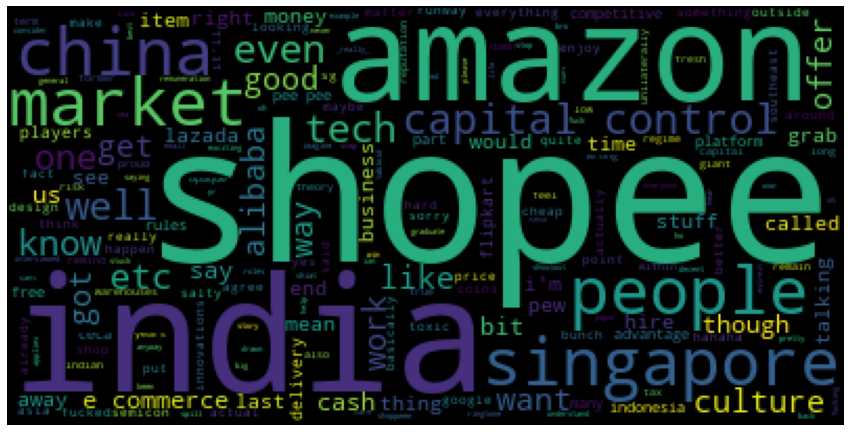

In [41]:
plt.figure(figsize=(15,10))
plt.clf()
plt.imshow(wordcloud_pos)
plt.axis('off')
plt.show()